# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-Events)
    - [Run Value by Count](#Run-Value-by-Count)
- [4-Seam Analysis](#4-Seam-Analysis)
    - [Top 10 4-Seam xRV/100](#Top-10-4-Seam-xRV/100)
    - [4-Seam HB & VB](#4-Seam-HB-&-VB)
    - [Best 4-Seam Heatmaps](#Best-4-Seam-Heatmaps)
- [Cutter Analysis](#Cutter-Analysis)
    - [Top 10 Cutter xRV/100](#Top-10-Cutter-xRV/100)
    - [Cutter HB & VB](#Cutter-HB-&-VB)
    - [Best Cutter Heatmaps](#Best-Cutter-Heatmaps)
- [Sinker Analysis](#Sinker-Analysis)
    - [Top 10 Sinker xRV/100](#Top-10-Sinker-xRV/100)
    - [Sinker HB & VB](#Sinker-HB-&-VB)
    - [Best Sinker Heatmaps](#Best-Sinker-Heatmaps)
- [Slider Analysis](#Slider-Analysis)
    - [Top 10 Slider xRV/100](#Top-10-Slider-xRV/100)
    - [Slider HB & VB](#Slider-HB-&-VB)
    - [Best Slider Heatmaps](#Best-Slider-Heatmaps)
- [Curveball Analysis](#Curveball-Analysis)
    - [Top 10 Curveball xRV/100](#Top-10-Curveball-xRV/100)
    - [Curveball HB & VB](#Curveball-HB-&-VB)
    - [Best Curveball Heatmaps](#Best-Curveball-Heatmaps)
- [Changeup Analysis](#Changeup-Analysis)
    - [Top 10 Changeup xRV/100](#Top-10-Changeup-xRV/100)
    - [Changeup HB & VB](#Changeup-HB-&-VB)
    - [Best Changeup Heatmaps](#Best-Changeup-Heatmaps)

# Imports

In [52]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [53]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

xrv = pd.read_csv('../data/xrv-pitches.csv', index_col = [0])
rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])
grouped_pitches_rv = pd.read_csv('../data/grouped-pitches-rv-table.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv.shape)
xrv.head()

(680883, 14)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,rv,n_pitches,xRV
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,28.8,6.3,0.017,1,0.010
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,40.1,6.7,-0.053,1,0.025
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,40.1,6.6,-0.214,1,-0.138
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,20.1,6.7,-0.245,1,-0.165
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,20.1,6.6,-0.034,1,0.011


In [54]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 13)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,92.6,9.58,17.19,43.3,6.19,4.322,2.09,4.288,2.07
1,"Abreu, Albert",R,FF,103.0,97.8,11.69,15.42,40.8,6.44,-2.370,-2.30,-3.120,-3.03
2,"Abreu, Bryan",R,FF,310.0,95.7,8.00,17.05,28.7,6.33,-4.108,-1.33,-7.193,-2.32
3,"Acevedo, Domingo",R,FF,88.0,92.9,12.23,15.09,31.0,5.76,1.625,1.85,1.592,1.81
4,"Adam, Jason",R,FF,125.0,93.8,7.03,16.76,34.5,6.73,1.763,1.41,-2.173,-1.74


In [55]:
print(grouped_pitches_rv.shape)
grouped_pitches_rv.head()

(3469, 20)


,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,velo,pfx_x,pfx_z,arm_angle,release_extension,RV,RV/100,xRV,xRV/100,CU_count,SL_count,KC_count,CH_count,FS_count
0,"Abbott, Cory",R,FF,207.0,0.0,0.0,92.6,9.58,17.19,43.30,6.19,4.322,2.09,0.786,0.38,0.0,0.0,0.0,0.0,0.0
1,"Abreu, Albert",R,FF,103.0,0.0,0.0,97.9,14.14,13.97,40.93,6.46,-2.370,-2.30,-3.191,-3.10,0.0,0.0,0.0,0.0,0.0
2,"Abreu, Albert",R,SI,0.0,212.0,0.0,97.9,14.14,13.97,40.93,6.46,-2.181,-1.03,-7.404,-3.49,0.0,0.0,0.0,0.0,0.0
3,"Abreu, Bryan",R,FF,310.0,0.0,0.0,95.7,8.04,17.04,28.73,6.33,-4.108,-1.33,-4.576,-1.48,0.0,0.0,0.0,0.0,0.0
4,"Abreu, Bryan",R,SI,0.0,2.0,0.0,95.7,8.04,17.04,28.73,6.33,-0.025,-1.25,-0.054,-2.70,0.0,0.0,0.0,0.0,0.0


# Preprocessing

In [56]:
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [57]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'arm_angle',
                 'release_extension', 'rv']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

print(vif_data.sort_values(by = 'VIF'))

             feature         VIF
8                 rv    1.011820
2              pfx_x    1.381995
4      release_pos_x    2.456688
3              pfx_z    3.112930
6          arm_angle    8.860496
1          spin_rate   50.640764
5      release_pos_z  127.152933
7  release_extension  162.940014
0               velo  298.874018


# Analysis

### Run Value for Ball in Play Events

In [58]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.770147,1.041,1.259,0.692604
1,field_error,0.445453,0.716,0.866,0.361452
2,field_out,-0.271404,0.000,0.000,-0.372342
3,hit_by_pitch,0.359255,0.630,0.762,0.407971
4,home_run,1.385794,1.657,2.003,1.312059
5,single,0.474625,0.746,0.902,0.393770
6,triple,1.062984,1.334,1.613,0.985045
7,walk,0.332291,0.603,0.729,0.507749


### Run Value by Count

In [59]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'rv'].mean()

,pitch_count,woba,wraa_change,rv
0,0-0,0.314,-0.009615,-0.001308
1,0-1,0.265,-0.018637,-0.011327
2,0-2,0.197,-0.067643,-0.116486
3,1-0,0.356,-0.008226,0.001337
4,1-1,0.300,-0.021004,-0.008173
...,...,...,...,...
7,2-1,0.357,-0.018046,-0.003310
8,2-2,0.269,-0.105299,-0.151159
9,3-0,0.540,0.006415,0.129337
10,3-1,0.477,-0.006323,0.110551


### Average Run Value by Pitch Type

In [60]:
rv_pitches.groupby(['pitch_type'], as_index = False, sort = False)['RV/100', 'xRV/100'].mean()

,pitch_type,RV/100,xRV/100
0,FF,-1.354981,-1.187497
1,FC,-0.712389,-1.001903
2,SI,-0.997583,-0.682947
3,SL,-2.981076,-2.985712
4,CU,-1.843205,-1.909081
5,CH,-1.851334,-1.922699


# 4-Seam Analysis

In [61]:
ff_stats = xrv.loc[xrv['pitch_type'] == 'FF']
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

ff_r_avg = ff_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ff_l_avg = ff_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ff_avg = pd.concat([ff_r_avg, ff_l_avg], ignore_index = True)
ff_avg = ff_avg.round(1)
ff_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,FF,R,94.1,2283.3,7.1,16.1,5.9,6.4
1,FF,L,92.8,2249.4,-7.5,16.2,6.0,6.3


In [62]:
ff_stats[['rv', 'xRV']].describe()

,rv,xRV
count,249663.000000,249663.000000
mean,-0.024296,-0.020867
std,0.272280,0.155675
min,-1.818000,-1.210000
25%,-0.060000,-0.062000
50%,-0.034000,-0.023000
75%,0.028000,0.017000
max,3.726000,2.531000


### Top 10 4-Seam xRV/100

In [63]:
ff_stats['RV/100'] = ((ff_stats['rv'] / ff_stats['n_pitches']) * 100)
ff_stats['xRV/100'] = ((ff_stats['xRV'] / ff_stats['n_pitches']) * 100)

cols = list(ff_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
ff_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    ff_stats[col_zscore] = ((ff_stats[col] - ff_stats[col].mean())/ ff_stats[col].std(ddof=0) * -1)

stats = ff_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
ff_stats = pd.merge(ff_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
ff_stats['Qual'] = ff_stats['rv_zscore_y'] + 100
ff_stats['xQual'] = ff_stats['xRV_zscore_y'] + 100
ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

q_stats = ff_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
ff_leaders = stats.sort_values(by = ['xQual'], ascending = False)
ff_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
765,"Wheeler, Zack",R,FF,1353,97.17,7.65,15.91,-63.86,-4.72,213.82,-68.05,-5.03,355.79
584,"Ray, Robbie",L,FF,1864,94.78,-8.18,17.13,-82.44,-4.42,236.43,-75.50,-4.05,335.09
137,"Cole, Gerrit",R,FF,1397,97.67,11.99,17.96,-61.21,-4.38,200.16,-62.93,-4.50,317.00
272,"Green, Chad",R,FF,853,95.69,4.47,19.32,-44.84,-5.26,188.57,-50.12,-5.88,307.60
783,"Woodruff, Brandon",R,FF,940,96.52,6.35,16.64,-54.18,-5.76,215.11,-50.82,-5.41,300.45
416,"Lynn, Lance",R,FF,1051,93.99,6.03,14.94,-49.90,-4.75,189.50,-50.89,-4.84,286.00
801,"deGrom, Jacob",R,FF,704,99.21,9.07,16.45,-40.22,-5.71,184.88,-42.15,-5.99,276.40
642,"Scherzer, Max",R,FF,1316,94.30,10.61,16.03,-57.00,-4.33,191.92,-51.59,-3.92,255.01
602,"Rodríguez, Richard",R,FF,812,93.09,13.43,15.17,-40.51,-4.99,176.34,-41.04,-5.05,254.78
603,"Rodón, Carlos",L,FF,1302,95.36,-7.94,17.55,-60.01,-4.61,204.22,-50.45,-3.87,249.52


In [64]:
ff_leaders.describe()

,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
count,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000
mean,310.912827,93.305093,3.331432,15.498742,-7.553935,-1.354994,99.999963,-6.487908,-1.187497,100.000037
std,333.825626,2.611128,7.387500,2.961267,12.637241,6.379000,27.511151,11.350551,4.105874,46.153966
min,1.000000,74.450000,-18.940000,-13.500000,-82.440000,-26.750000,0.590000,-75.500000,-18.900000,-109.470000
25%,48.500000,91.920000,-1.875000,14.330000,-11.025000,-3.800000,87.080000,-9.110000,-3.110000,78.965000
50%,200.000000,93.500000,5.710000,15.890000,-2.690000,-1.950000,97.730000,-2.100000,-1.590000,97.400000
75%,460.500000,94.860000,8.520000,17.420000,0.025000,0.115000,106.570000,0.115000,0.355000,110.035000
max,1864.000000,100.630000,17.660000,22.300000,11.850000,71.550000,236.430000,13.180000,42.950000,355.790000


## RHP 4-Seam HB & VB

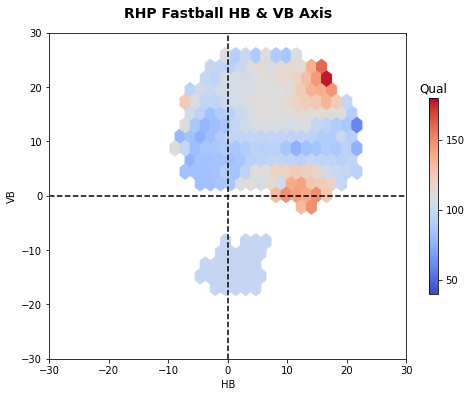

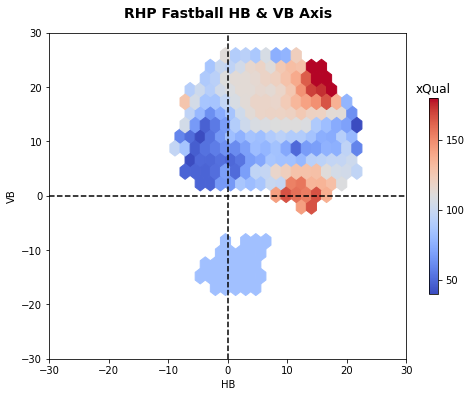

In [65]:
plt.figure(figsize = (8, 6))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(ff_r_stats['pfx_x'], ff_r_stats['pfx_z'], C = ff_r_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## LHP 4-Seam HB & VB

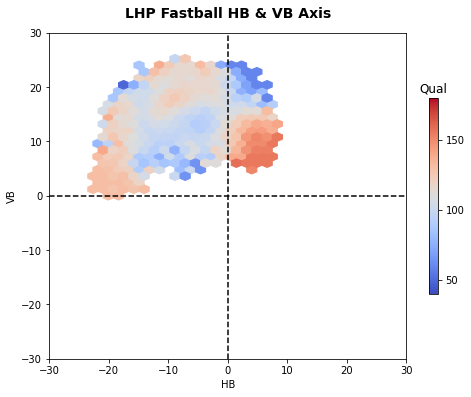

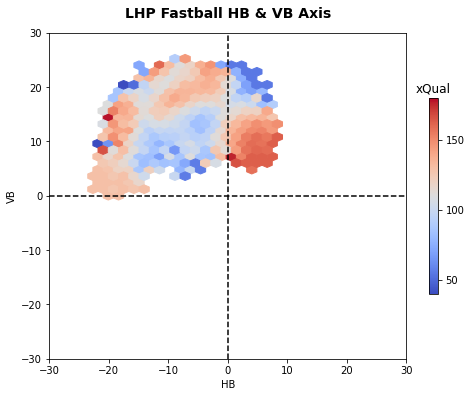

In [66]:
plt.figure(figsize = (8, 6))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['Qual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(ff_l_stats['pfx_x'], ff_l_stats['pfx_z'], C = ff_l_stats['xQual'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Cutter Analysis

In [67]:
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']
fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']

fc_r_avg = fc_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
fc_l_avg = fc_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
fc_avg = pd.concat([fc_r_avg, fc_l_avg], ignore_index = True)
fc_avg = fc_avg.round(1)
fc_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,FC,R,89.5,2422.6,-3.0,7.9,5.9,6.3
1,FC,L,86.8,2267.2,1.7,7.9,5.8,6.2


In [68]:
fc_stats[['rv', 'xRV']].describe()

,rv,xRV
count,47442.000000,47442.000000
mean,-0.024137,-0.021727
std,0.279081,0.158494
min,-1.920000,-1.233000
25%,-0.060000,-0.064000
50%,-0.034000,-0.024000
75%,0.028000,0.017000
max,3.306000,2.348000


### Top 10 Cutter xQual

In [69]:
fc_stats['RV/100'] = ((fc_stats['rv'] / fc_stats['n_pitches']) * 100)
fc_stats['xRV/100'] = ((fc_stats['xRV'] / fc_stats['n_pitches']) * 100)

cols = list(fc_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
fc_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fc_stats[col_zscore] = ((fc_stats[col] - fc_stats[col].mean())/ fc_stats[col].std(ddof=0) * -1)

stats = fc_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
fc_stats = pd.merge(fc_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
fc_stats['Qual'] = fc_stats['rv_zscore_y'] + 100
fc_stats['xQual'] = fc_stats['xRV_zscore_y'] + 100
fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']
q_stats = fc_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
fc_leaders = stats.sort_values(by = ['xQual'], ascending = False)
fc_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
31,"Burnes, Corbin",R,FC,1354,95.23,-4.19,11.17,-51.97,-3.84,169.10,-53.15,-3.93,249.71
113,"Lynn, Lance",R,FC,775,88.67,-2.71,4.84,-35.78,-4.62,161.18,-36.70,-4.74,225.32
64,"Garcia, Luis",R,FC,565,86.10,-5.69,5.22,-37.78,-6.69,186.52,-27.60,-4.89,196.69
160,"Quantrill, Cal",R,FC,585,88.42,-2.55,6.18,-23.12,-3.95,132.24,-25.95,-4.44,183.54
9,"Anderson, Tyler",L,FC,702,85.02,2.15,9.75,-36.64,-5.22,170.56,-27.05,-3.85,174.41
38,"Clase, Emmanuel",R,FC,722,100.22,-2.73,10.66,-31.52,-4.37,150.52,-26.08,-3.61,165.59
194,"Thompson, Zach",R,FC,419,87.06,-3.78,5.44,-20.01,-4.78,135.48,-18.97,-4.53,162.27
23,"Bleier, Richard",L,FC,158,87.25,1.05,5.37,-11.21,-7.09,126.50,-13.17,-8.34,161.45
4,"Alvarado, José",L,FC,170,94.11,1.26,5.10,-14.38,-8.46,136.81,-13.39,-7.88,161.19
32,"Burr, Ryan",R,FC,238,86.68,-4.79,-1.13,-15.66,-6.58,135.52,-14.65,-6.15,159.78


## RHP Cutter HB & VB

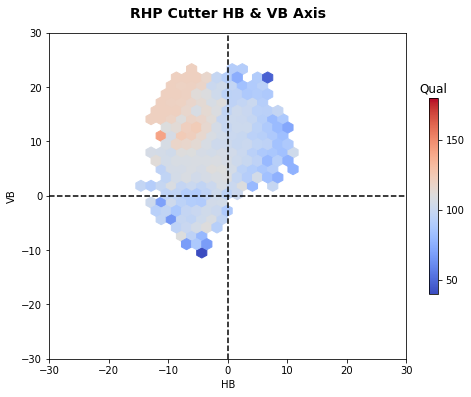

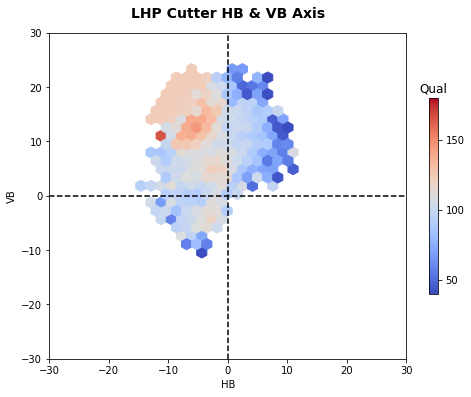

In [70]:
plt.figure(figsize = (8, 6))
plt.hexbin(fc_r_stats['pfx_x'], fc_r_stats['pfx_z'], C =fc_r_stats['Qual'], cmap ='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fc_r_stats['pfx_x'],fc_r_stats['pfx_z'],C = fc_r_stats['xQual'],cmap = 'coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## RHP Cutter HB & VB

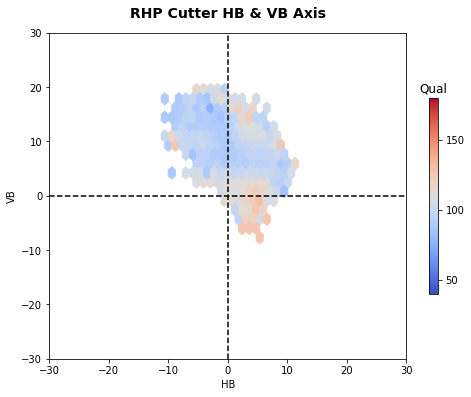

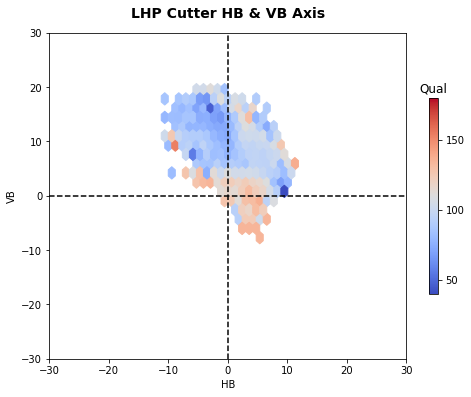

In [71]:
plt.figure(figsize = (8, 6))
plt.hexbin(fc_l_stats['pfx_x'], fc_l_stats['pfx_z'], C = fc_l_stats['Qual'],cmap='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fc_l_stats['pfx_x'], fc_l_stats['pfx_z'], C = fc_l_stats['xQual'],cmap='coolwarm',mincnt=1,gridsize=20)
cb = plt.colorbar(ticks = [50,100, 150], shrink = .6)
cb.ax.set_title('Qual'), plt.clim(40, 180)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Sinker Analysis

In [72]:
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']
si_stats = si_stats.round(1)
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']

si_r_avg = si_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
si_l_avg = si_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
si_avg = pd.concat([si_r_avg, si_l_avg], ignore_index = True)
si_avg = si_avg.round(1)
si_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SI,R,93.4,2143.9,14.8,9.2,5.7,6.3
1,SI,L,92.1,2077.2,-15.0,9.3,5.8,6.3


In [73]:
si_stats[['rv', 'xRV']].describe()

,rv,xRV
count,109145.000000,109145.000000
mean,-0.016257,-0.012848
std,0.283671,0.162234
min,-1.800000,-1.300000
25%,-0.100000,-0.100000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3.300000,2.300000


### Top 10 Sinker xQual

In [74]:
si_stats['RV/100'] = ((si_stats['rv'] / si_stats['n_pitches']) * 100)
si_stats['xRV/100'] = ((si_stats['xRV'] / si_stats['n_pitches']) * 100)

cols = list(si_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
si_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    si_stats[col_zscore] = ((si_stats[col] - si_stats[col].mean())/ si_stats[col].std(ddof=0) * -1)

stats = si_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
si_stats = pd.merge(si_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
si_stats['Qual'] = si_stats['rv_zscore_y'] + 100
si_stats['xQual'] = si_stats['xRV_zscore_y'] + 100
si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']
q_stats = si_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                           as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 
                                             'xRV/100', 'Qual', 'xQual'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'Qual', 'xRV', 'xRV/100', 'xQual'])
si_leaders = stats.sort_values(by = ['xQual'], ascending = False)
si_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,Qual,xRV,xRV/100,xQual
216,"Houser, Adrian",R,SI,1263,93.57,15.95,7.79,-46.0,-3.64,189.78,-53.6,-4.24,330.36
436,"Suárez, Ranger",L,SI,734,92.95,-15.77,7.82,-44.5,-6.06,214.81,-46.1,-6.28,326.03
285,"Matz, Steven",L,SI,1327,94.47,-15.04,12.30,-41.6,-3.13,170.60,-47.6,-3.59,288.31
274,"Manaea, Sean",L,SI,1782,92.14,-13.79,12.28,-66.1,-3.71,230.89,-51.6,-2.90,276.93
262,"Loáisiga, Jonathan",R,SI,595,98.31,15.60,11.78,-33.4,-5.61,183.64,-32.0,-5.38,250.13
484,"Wheeler, Zack",R,SI,580,96.70,15.70,11.43,-30.6,-5.28,174.63,-29.7,-5.12,237.14
473,"Wainwright, Adam",R,SI,860,89.05,12.74,12.29,-44.1,-5.13,206.18,-32.9,-3.83,234.69
7,"Alcantara, Sandy",R,SI,874,97.61,17.27,7.34,-26.6,-3.04,143.68,-30.9,-3.54,221.25
494,"Woodruff, Brandon",R,SI,749,96.24,13.96,12.77,-27.7,-3.70,154.72,-27.8,-3.71,212.04
260,"Loup, Aaron",L,SI,431,92.35,-19.52,3.86,-22.8,-5.29,155.67,-23.3,-5.41,209.49


In [47]:
si_stats.head()

,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,rv_x,n_pitches_x,xRV_x,RV/100,xRV/100,rv_zscore_x,xRV_zscore_x,RV/100_zscore,xRV/100_zscore,n_pitches_y,rv_y,xRV_y,rv_zscore_y,xRV_zscore_y,Qual,xQual
0,"Gsellman, Robert",R,SI,94.3,1982.0,16.2,10.6,1.2,6.0,29.8,6.5,-0.2,1,-0.2,-20.0,-20.0,0.647736,1.153595,0.647736,1.153595,246,-5.3,-5.2,4.585307,12.570632,104.585307,112.570632
1,"Gsellman, Robert",R,SI,94.3,1930.0,18.2,5.9,1.3,6.0,29.8,6.4,-0.0,1,-0.1,-0.0,-10.0,-0.057311,0.537200,-0.057311,0.537200,246,-5.3,-5.2,4.585307,12.570632,104.585307,112.570632
2,"Gsellman, Robert",R,SI,94.2,2102.0,17.0,6.4,1.4,5.9,29.8,6.4,-0.0,1,-0.0,-0.0,-0.0,-0.057311,-0.079195,-0.057311,-0.079195,246,-5.3,-5.2,4.585307,12.570632,104.585307,112.570632
3,"Gsellman, Robert",R,SI,94.1,2033.0,15.4,4.3,1.3,6.0,29.8,6.4,-0.1,1,-0.1,-10.0,-10.0,0.295212,0.537200,0.295212,0.537200,246,-5.3,-5.2,4.585307,12.570632,104.585307,112.570632
4,"Gsellman, Robert",R,SI,93.6,2019.0,15.5,7.0,1.4,5.9,29.8,6.5,-0.1,1,-0.1,-10.0,-10.0,0.295212,0.537200,0.295212,0.537200,246,-5.3,-5.2,4.585307,12.570632,104.585307,112.570632


## Sinker HB & VB

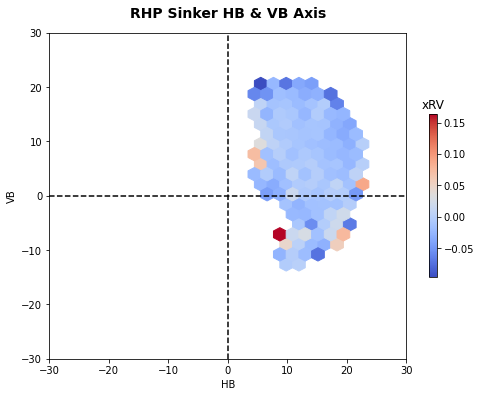

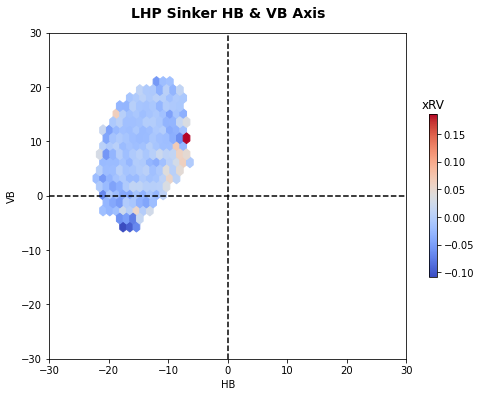

In [21]:
plt.figure(figsize = (8, 6))
plt.hexbin(si_r_stats['pfx_x'], si_r_stats['pfx_z'], C = si_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 15, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(si_l_stats['pfx_x'], si_l_stats['pfx_z'], C = si_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Slider Analysis

In [22]:
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

sl_r_avg = sl_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
sl_l_avg = sl_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
sl_avg = pd.concat([sl_r_avg, sl_l_avg], ignore_index = True)
sl_avg = sl_avg.round(1)
sl_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,SL,R,84.9,2438.2,-6.3,1.8,5.8,6.3
1,SL,L,83.9,2357.1,5.8,1.5,5.9,6.2


In [23]:
sl_stats[['rv', 'xRV']].describe()

,rv,xRV
count,135533.000000,135533.000000
mean,-0.040556,-0.039908
std,0.280246,0.158921
min,-1.760000,-1.368000
25%,-0.067000,-0.080000
50%,-0.034000,-0.033000
75%,0.028000,0.007000
max,3.707000,2.373000


### Top 10 Slider xRV/100

In [24]:
sl_leaders = sl.sort_values(by = ['xRV/100'])
sl_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
sl_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
1714,"Graterol, Brusdar",R,SL,164.0,88.1,-9.22,4.36,27.6,5.58,-16.591,-10.12
2072,"Bummer, Aaron",L,SL,281.0,83.0,17.92,-5.02,81.8,6.01,-27.761,-9.88
2085,"Davidson, Tucker",L,SL,123.0,86.8,3.70,0.85,38.9,6.07,-12.085,-9.83
1623,"Clase, Emmanuel",R,SL,310.0,91.9,-6.20,0.81,12.1,6.40,-29.158,-9.41
1739,"Hendriks, Liam",R,SL,235.0,89.0,-1.91,3.24,30.4,6.86,-21.230,-9.03
2084,"Crochet, Garrett",L,SL,255.0,85.2,11.91,0.74,47.1,6.85,-22.572,-8.85
2178,"Rodón, Carlos",L,SL,603.0,85.8,8.21,-1.06,66.6,6.00,-52.274,-8.67
1597,"Burnes, Corbin",R,SL,238.0,88.0,-7.56,-0.22,17.8,6.38,-20.036,-8.42
1817,"Maples, Dillon",R,SL,201.0,87.5,-14.51,-0.56,31.4,6.04,-16.832,-8.37
1593,"Buehler, Walker",R,SL,433.0,84.9,-14.19,0.79,20.0,6.43,-35.803,-8.27


## Slider HB & VB

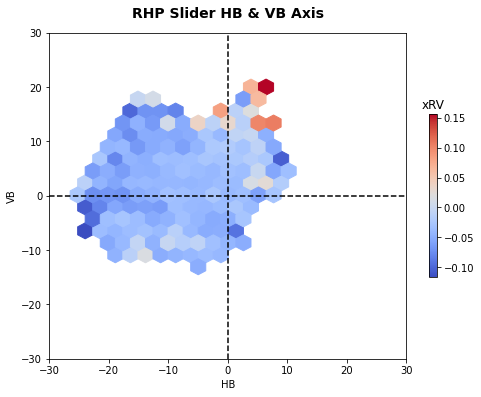

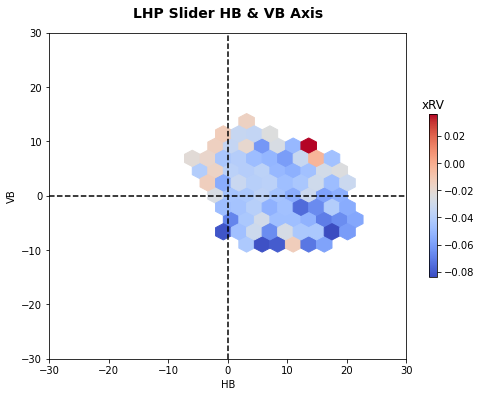

In [25]:
plt.figure(figsize = (8, 6))
plt.hexbin(sl_r_stats['pfx_x'], sl_r_stats['pfx_z'], C = sl_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 12, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(sl_l_stats['pfx_x'], sl_l_stats['pfx_z'], C = sl_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 25, gridsize = 15)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Curveball Analysis

In [26]:
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

cu_r_avg = cu_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
cu_l_avg = cu_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
cu_avg = pd.concat([cu_r_avg, cu_l_avg], ignore_index = True)
cu_avg = cu_avg.round(1)
cu_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,CU,R,79.2,2538.3,-9.6,-9.3,6.0,6.2
1,CU,L,77.7,2439.9,8.4,-7.5,6.0,6.1


In [27]:
cu_stats[['rv', 'xRV']].describe()

,rv,xRV
count,58770.000000,58770.000000
mean,-0.038081,-0.037706
std,0.254521,0.147085
min,-2.012000,-1.184000
25%,-0.053000,-0.073000
50%,-0.034000,-0.029000
75%,0.028000,0.008000
max,3.306000,2.204000


### Top 10 Curveball xRV/100

In [28]:
cu_leaders = cu.sort_values(by = ['xRV/100'])
cu_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
cu_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
2329,"Glasnow, Tyler",R,CU,183.0,83.5,-4.63,-17.54,27.0,7.17,-25.497,-13.93
2245,"Bassitt, Chris",R,CU,155.0,71.7,-13.57,-13.51,17.1,6.32,-16.911,-10.91
2456,"Petit, Yusmeiro",R,CU,147.0,74.9,-9.71,-0.00,11.1,6.95,-13.969,-9.50
2633,"Mantiply, Joe",L,CU,186.0,80.8,7.59,-3.25,107.8,6.34,-16.844,-9.06
2275,"Castellanos, Humberto",R,CU,183.0,76.2,-9.70,-5.16,38.6,5.98,-16.105,-8.80
2693,"Zimmermann, Bruce",L,CU,146.0,81.9,1.07,-6.04,17.6,6.16,-12.053,-8.26
2638,"McClanahan, Shane",L,CU,321.0,82.5,6.03,-10.68,18.1,6.80,-25.933,-8.08
2630,"Luetge, Lucas",L,CU,189.0,74.5,12.36,-15.41,7.0,6.17,-14.953,-7.91
2399,"Lugo, Seth",R,CU,208.0,79.2,-12.06,-17.28,26.0,5.71,-16.418,-7.89
2686,"Valdez, Framber",L,CU,643.0,77.9,13.52,-15.30,33.2,5.85,-49.306,-7.67


## Curveball HB & VB

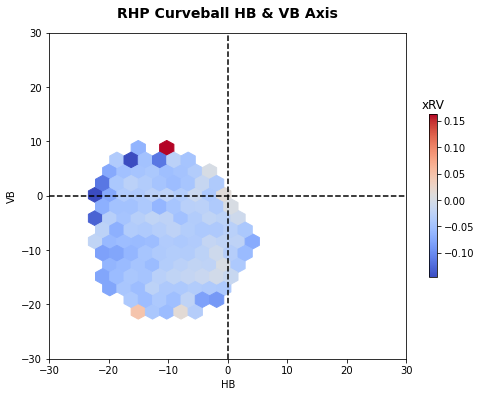

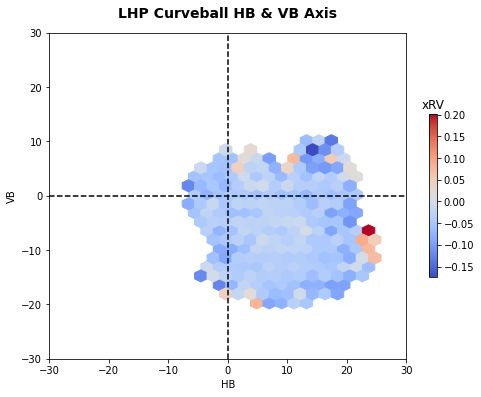

In [29]:
plt.figure(figsize = (8, 6))
plt.hexbin(cu_r_stats['pfx_x'], cu_r_stats['pfx_z'], C = cu_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(cu_l_stats['pfx_x'], cu_l_stats['pfx_z'], C = cu_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 5, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Changeup Analysis

In [30]:
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']
ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

ch_r_avg = ch_r_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ch_l_avg = ch_l_stats.groupby(['pitch_type', 'p_throws'], 
                              as_index = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                'release_pos_z', 'release_extension'].mean()
ch_avg = pd.concat([ch_r_avg, ch_l_avg], ignore_index = True)
ch_avg = ch_avg.round(1)
ch_avg.head()

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,CH,R,85.5,1756.8,13.8,6.3,5.8,6.3
1,CH,L,83.6,1737.4,-13.9,7.8,5.8,6.2


In [31]:
ch_stats[['rv', 'xRV']].describe()

,rv,xRV
count,80330.000000,80330.000000
mean,-0.031865,-0.029711
std,0.279578,0.158875
min,-1.770000,-1.079000
25%,-0.067000,-0.073000
50%,-0.034000,-0.026000
75%,0.032000,0.015000
max,3.306000,2.249000


### Top 10 Changeup xRV/100

In [32]:
ch_leaders = ch.sort_values(by = ['xRV/100'])
ch_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
ch_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
3245,"King, John",L,CH,131.0,78.4,-13.56,6.74,68.7,5.900000,-13.731,-10.48
3302,"Rodríguez, Joely",L,CH,284.0,88.4,-11.20,0.34,133.5,6.340000,-22.819,-8.03
2749,"Buehler, Walker",R,CH,151.0,91.5,13.02,5.36,25.2,6.318543,-11.627,-7.70
3099,"Sulser, Cole",R,CH,355.0,84.0,13.49,5.60,32.6,6.701408,-26.860,-7.57
3097,"Stripling, Ross",R,CH,256.0,83.1,10.23,10.59,23.1,6.012500,-18.679,-7.30
3021,"Petit, Yusmeiro",R,CH,191.0,80.8,11.41,14.86,37.5,7.117277,-13.952,-7.30
3331,"Urías, Julio",L,CH,483.0,86.8,-14.58,7.23,51.5,5.800000,-34.952,-7.24
3165,"deGrom, Jacob",R,CH,109.0,91.4,14.18,2.76,22.0,6.962385,-7.662,-7.03
3066,"Scherzer, Max",R,CH,421.0,85.0,15.16,3.95,49.4,6.435629,-29.544,-7.02
2829,"Feyereisen, J.P.",R,CH,194.0,87.6,14.88,2.64,25.3,5.904639,-13.498,-6.96


### Changeup HB & VB

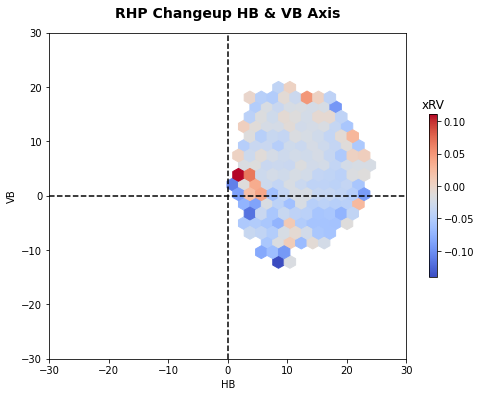

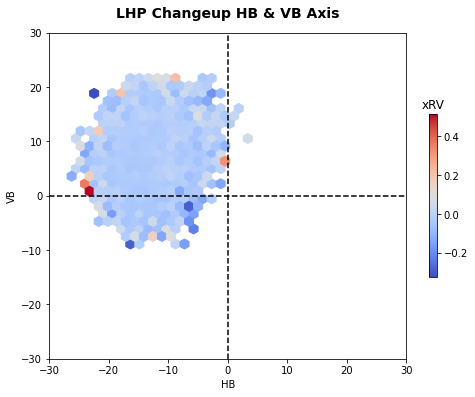

In [33]:
plt.figure(figsize = (8, 6))
plt.hexbin(ch_r_stats['pfx_x'], ch_r_stats['pfx_z'], C = ch_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(ch_l_stats['pfx_x'], ch_l_stats['pfx_z'], C = ch_l_stats['xRV'], cmap = 'coolwarm', gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xRV')
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

# Grouped Pitches

## Fastball
4-Seam, Cutter, Sinker

In [34]:
fastball_stats = xrv[xrv['pitch_type'].isin(['FF', 'FC', 'SI'])]
fastball_r_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'R']
fastball_l_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'L']

fastball_r_avg = fastball_r_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
fastball_l_avg = fastball_l_stats.groupby(['pitch_type', 'p_throws'], 
                                          as_index = False, 
                                          sort = False)['velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                                                        'release_pos_z', 'release_extension'].mean()
fastball_avg = pd.concat([fastball_r_avg, fastball_l_avg], ignore_index = True)
fastball_avg = fastball_avg.round(1)
fastball_avg.head(6)

,pitch_type,p_throws,velo,spin_rate,pfx_x,pfx_z,release_pos_z,release_extension
0,FF,R,94.1,2283.3,7.1,16.1,5.9,6.4
1,FC,R,89.5,2422.6,-3.0,7.9,5.9,6.3
2,SI,R,93.4,2143.9,14.8,9.2,5.7,6.3
3,FF,L,92.8,2249.4,-7.5,16.2,6.0,6.3
4,FC,L,86.8,2267.2,1.7,7.9,5.8,6.2
5,SI,L,92.1,2077.2,-15.0,9.3,5.8,6.3


In [35]:
fastball_stats[['rv', 'xRV']].describe()

,rv,xRV
count,406250.000000,406250.000000
mean,-0.022264,-0.019074
std,0.275709,0.157274
min,-1.920000,-1.340000
25%,-0.060000,-0.061000
50%,-0.034000,-0.022000
75%,0.028000,0.018000
max,3.726000,2.531000


In [36]:
fastball_stats['RV/100'] = ((fastball_stats['rv'] / fastball_stats['n_pitches']) * 100)
fastball_stats['xRV/100'] = ((fastball_stats['xRV'] / fastball_stats['n_pitches']) * 100)
fastball_stats.head()

cols = list(fastball_stats[['rv', 'xRV', 'RV/100', 'xRV/100']])
fastball_stats[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fastball_stats[col_zscore] = ((fastball_stats[col] - 
                                  fastball_stats[col].mean())/ fastball_stats[col].std(ddof=0) * -1)

#fastball_stats['Qual'] = round(((((fastball_stats['RV/100_zscore']) * fastball_stats['RV/100_zscore'].std()) +
#                                 fastball_stats['RV/100_zscore'].mean()) * -1), 2)
#fastball_stats['xQual'] = round((((fastball_stats['xRV/100_zscore'] * fastball_stats['xRV/100_zscore'].std())
#                                + fastball_stats['xRV/100_zscore'].mean())* -1), 2)
fastball_r_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'R']
fastball_l_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'L']
#fastball_stats.to_csv('../data/fastball-quality.csv')
fastball_stats.head()

,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,slot,release_extension,rv,n_pitches,xRV,RV/100,xRV/100,rv_zscore,xRV_zscore,RV/100_zscore,xRV/100_zscore
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,28.8,overhead,6.3,0.017,1,0.023,1.7,2.3,-0.142411,-0.267521,-0.142411,-0.267521
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,40.1,sidearm,6.7,-0.053,1,0.112,-5.3,11.2,0.111481,-0.833415,0.111481,-0.833415
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,40.1,sidearm,6.6,-0.214,1,-0.128,-21.4,-12.8,0.695430,0.692591,0.695430,0.692591
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,20.1,overhead,6.7,-0.245,1,-0.174,-24.5,-17.4,0.807868,0.985075,0.807868,0.985075
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,20.1,overhead,6.6,-0.034,1,0.046,-3.4,4.6,0.042567,-0.413763,0.042567,-0.413763


In [37]:
stats = fastball_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['n_pitches', 'rv', 'xRV', 
                                         'rv_zscore', 'xRV_zscore'].sum()
fastball_stats = pd.merge(fastball_stats, stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
fastball_stats['Qual'] = fastball_stats['rv_zscore_y'] + 100
fastball_stats['xQual'] = fastball_stats['xRV_zscore_y'] + 100
fastball_r_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'R']
fastball_l_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'L']
q_stats = fastball_stats.groupby(['player_name', 'p_throws', 'pitch_type'], 
                       as_index = False)['velo', 'pfx_x', 'pfx_z', 'RV/100', 'xRV/100'].mean()

stats = pd.merge(stats, q_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
stats = stats.round(2)
stats = stats.reindex(columns = ['player_name', 'p_throws', 'pitch_type', 'n_pitches', 'velo', 
                                 'pfx_x', 'pfx_z', 'rv', 'RV/100', 'rv_zscore', 'xRV', 'xRV/100', 'xRV_zscore'])
stats.head()

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,rv,RV/100,rv_zscore,xRV,xRV/100,xRV_zscore
0,"Abad, Fernando",L,FC,16,82.59,3.38,2.74,-0.54,-3.40,0.68,-0.18,-1.11,-0.82
1,"Abad, Fernando",L,FF,18,91.69,-5.34,16.20,2.28,12.69,-9.74,1.72,9.53,-13.09
2,"Abad, Fernando",L,SI,141,92.36,-13.19,12.92,-4.65,-3.30,5.49,-1.54,-1.09,-7.31
3,"Abbott, Cory",R,FF,207,92.60,9.58,17.19,4.32,2.09,-32.39,4.59,2.22,-54.30
4,"Abreu, Albert",R,FF,103,97.79,11.69,15.42,-2.37,-2.30,0.28,-3.19,-3.10,7.78


In [38]:
fastball_stats.head()

,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,slot,release_extension,rv_x,n_pitches_x,xRV_x,RV/100,xRV/100,rv_zscore_x,xRV_zscore_x,RV/100_zscore,xRV/100_zscore,n_pitches_y,rv_y,xRV_y,rv_zscore_y,xRV_zscore_y,Qual,xQual
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,28.8,overhead,6.3,0.017,1,0.023,1.7,2.3,-0.142411,-0.267521,-0.142411,-0.267521,22,-0.536,-0.363,0.167552,-0.360051,100.167552,99.639949
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,40.1,sidearm,6.7,-0.053,1,0.112,-5.3,11.2,0.111481,-0.833415,0.111481,-0.833415,266,-11.291,-6.495,19.472801,9.037346,119.472801,109.037346
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,40.1,sidearm,6.6,-0.214,1,-0.128,-21.4,-12.8,0.695430,0.692591,0.695430,0.692591,266,-11.291,-6.495,19.472801,9.037346,119.472801,109.037346
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,20.1,overhead,6.7,-0.245,1,-0.174,-24.5,-17.4,0.807868,0.985075,0.807868,0.985075,570,-16.386,-12.729,13.404055,11.806566,113.404055,111.806566
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,20.1,overhead,6.6,-0.034,1,0.046,-3.4,4.6,0.042567,-0.413763,0.042567,-0.413763,570,-16.386,-12.729,13.404055,11.806566,113.404055,111.806566


In [39]:
fastball_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,rv_x,n_pitches_x,xRV_x,RV/100,xRV/100,rv_zscore_x,xRV_zscore_x,RV/100_zscore,xRV/100_zscore,n_pitches_y,rv_y,xRV_y,rv_zscore_y,xRV_zscore_y,Qual,xQual
count,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.0,406250.000000,406250.000000,406250.000000,4.062500e+05,4.062500e+05,4.062500e+05,4.062500e+05,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000
mean,92.910522,2244.299131,3.102286,13.300776,0.657699,5.864830,41.301202,6.338833,-0.022264,1.0,-0.019074,-2.226384,-1.907393,2.116731e-13,-5.009775e-15,4.010275e-15,-1.845912e-15,617.750622,-15.996405,-13.769830,8.135061,12.633395,108.135061,112.633395
std,3.211609,206.380993,9.801343,5.236159,1.889133,0.534216,22.954575,0.439245,0.275709,0.0,0.157274,27.570900,15.727358,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,389.923793,16.503318,15.400854,40.450615,71.259722,40.450615,71.259722
min,59.200000,117.000000,-25.440000,-19.080000,-4.610000,0.970000,0.800000,3.600000,-1.920000,1.0,-1.340000,-192.000000,-134.000000,-1.359502e+01,-1.621427e+01,-1.359502e+01,-1.621427e+01,1.000000,-82.435000,-75.495000,-138.549554,-188.318324,-38.549554,-88.318324
25%,91.200000,2109.000000,-4.560000,10.080000,-1.310000,5.620000,27.400000,6.000000,-0.060000,1.0,-0.061000,-6.000000,-6.100000,-1.823078e-01,-2.357292e-01,-1.823078e-01,-2.357292e-01,313.000000,-25.451000,-21.718000,-16.680259,-27.496998,83.319741,72.503002
50%,93.300000,2243.000000,4.920000,14.520000,1.370000,5.900000,35.500000,6.300000,-0.034000,1.0,-0.022000,-3.400000,-2.200000,4.256727e-02,1.860498e-02,4.256727e-02,1.860498e-02,548.000000,-11.291000,-9.652000,0.516652,2.134843,100.516652,102.134843
75%,95.100000,2376.000000,10.800000,17.160000,2.020000,6.190000,46.600000,6.600000,0.028000,1.0,0.018000,2.800000,1.800000,1.368697e-01,2.665808e-01,1.368697e-01,2.665808e-01,874.000000,-3.546000,-2.743000,29.738931,47.343933,129.738931,147.343933
max,103.400000,3594.000000,29.040000,27.960000,4.640000,7.190000,168.400000,8.600000,3.726000,1.0,2.531000,372.600000,253.100000,6.883121e+00,8.398916e+00,6.883121e+00,8.398916e+00,1864.000000,17.583000,13.184000,148.472710,273.345475,248.472710,373.345475


### RHP Fastball HB & VB

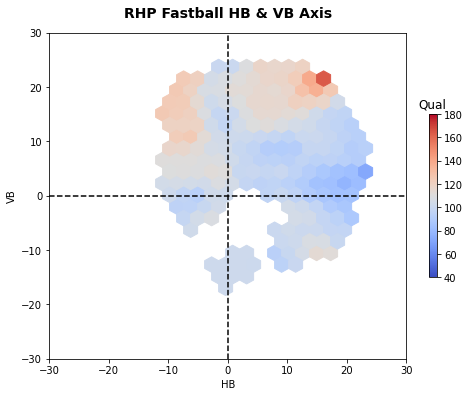

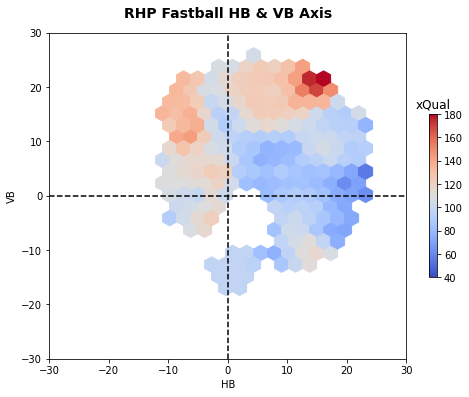

In [62]:
plt.figure(figsize = (8, 6))
plt.hexbin(fastball_r_stats['pfx_x'], fastball_r_stats['pfx_z'], C = fastball_r_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 15, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('Qual') 
plt.clim(40, 180)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fastball_r_stats['pfx_x'], fastball_r_stats['pfx_z'], C = fastball_r_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xQual')
plt.clim(40, 180)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball HB & VB

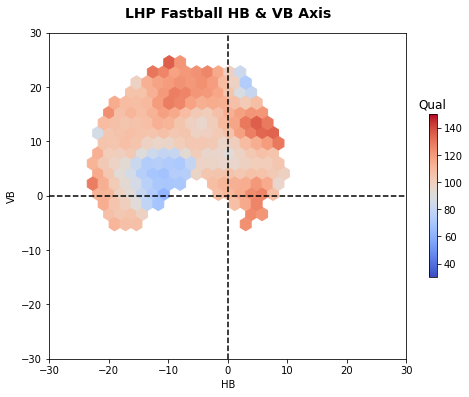

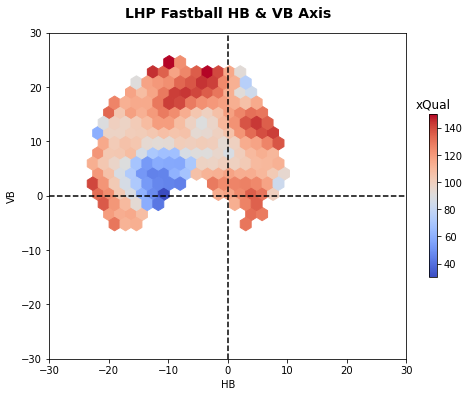

In [52]:
plt.figure(figsize = (8, 6))
plt.hexbin(fastball_l_stats['pfx_x'], fastball_l_stats['pfx_z'], C = fastball_l_stats['Qual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('Qual') 
plt.clim(30, 150)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fastball_l_stats['pfx_x'], fastball_l_stats['pfx_z'], C = fastball_l_stats['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30), cb.ax.set_title('xQual')
plt.clim(30, 150)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

If we have a negative z-score the corresponding raw score should be less than the mean, and a positive z-score must correspond to a raw score higher than the mean.

### Fastball xRV/100 Leaders

In [109]:
fastball_leaders = rv_pitches[rv_pitches['pitch_type'].isin(['FF', 'FC', 'SI'])]
fastball_leaders = fastball_leaders.sort_values(by = ['xRV/100'])
fastball_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
#fastball_leaders['quality'] = [-x if x > 0 else -x for x in fastball_leaders['xRV/100']]
fastball_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100
1528,"Vasquez, Andrew",L,SI,1.0,91.1,-13.44,-0.24,99.9,6.40,-0.289,-28.90
1500,"Rogers, Trevor",L,SI,1.0,94.9,-17.28,15.48,79.5,6.50,-0.258,-25.80
1278,"Ponce de Leon, Daniel",R,SI,1.0,91.7,15.48,18.36,32.7,6.20,-0.246,-24.60
1383,"Zimmer, Kyle",R,SI,3.0,94.9,6.32,15.88,12.0,6.27,-0.689,-22.97
909,"Peterson, Jace",R,FC,1.0,85.0,5.16,13.44,27.0,5.60,-0.214,-21.40
1412,"Chapman, Aroldis",L,SI,56.0,100.7,-12.99,16.03,13.7,7.12,-11.357,-20.28
9,"Alcántara, Sergio",R,FF,2.0,89.6,7.56,19.38,31.2,5.35,-0.368,-18.40
1163,"Gutierrez, Vladimir",R,SI,3.0,92.9,16.44,20.04,35.9,6.60,-0.542,-18.07
1096,"Crawford, Kutter",R,SI,2.0,95.8,10.98,17.64,36.8,6.50,-0.352,-17.60
433,"Reed, Jake",R,FF,4.0,92.6,13.98,10.62,55.9,5.30,-0.614,-15.35


In [91]:
scaler = StandardScaler(with_mean = False, with_std = False).fit(fastball_leaders[['quality']])
rv_scaled = scaler.transform(fastball_leaders[['quality']] + 150)

fastball_leaders['quality+'] = rv_scaled
fastball_leaders['quality+'] = round(fastball_leaders['quality+']).astype(int)
fastball_leaders.drop(columns = ['quality'], inplace = True)

fastball_r_lead = fastball_leaders.loc[fastball_leaders['p_throws'] == 'R']
fastball_l_lead = fastball_leaders.loc[fastball_leaders['p_throws'] == 'L']
fastball_r_lead['velo_bucket'] = pd.qcut(fastball_r_lead['velo'], 4, labels = [1, 2, 3, 4])
fastball_l_lead['velo_bucket'] = pd.qcut(fastball_l_lead['velo'], 4, labels = [1, 2, 3, 4])
bucket_1_r = fastball_r_lead.loc[fastball_r_lead['velo_bucket'] == 1]
bucket_2_r = fastball_r_lead.loc[fastball_r_lead['velo_bucket'] == 2]
bucket_3_r = fastball_r_lead.loc[fastball_r_lead['velo_bucket'] == 3]
bucket_4_r = fastball_r_lead.loc[fastball_r_lead['velo_bucket'] == 4]

bucket_1_l = fastball_l_lead.loc[fastball_l_lead['velo_bucket'] == 1]
bucket_2_l = fastball_l_lead.loc[fastball_l_lead['velo_bucket'] == 2]
bucket_3_l = fastball_l_lead.loc[fastball_l_lead['velo_bucket'] == 3]
bucket_4_l = fastball_l_lead.loc[fastball_l_lead['velo_bucket'] == 4]

fastball_leaders.head()

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100,quality+
1528,"Vasquez, Andrew",L,SI,1.0,91.1,-13.44,-0.24,99.9,6.40,-0.289,-28.90,179
1500,"Rogers, Trevor",L,SI,1.0,94.9,-17.28,15.48,79.5,6.50,-0.258,-25.80,176
1278,"Ponce de Leon, Daniel",R,SI,1.0,91.7,15.48,18.36,32.7,6.20,-0.246,-24.60,175
1383,"Zimmer, Kyle",R,SI,3.0,94.9,6.32,15.88,12.0,6.27,-0.689,-22.97,173
909,"Peterson, Jace",R,FC,1.0,85.0,5.16,13.44,27.0,5.60,-0.214,-21.40,171


bucket 1: 74.4 - 91.1

bucket 2: 91.2 - 93.2

bucket 3: 93.3 - 94.8

bucket 4: 94.9 - 100.6

### Fastball HB & VB

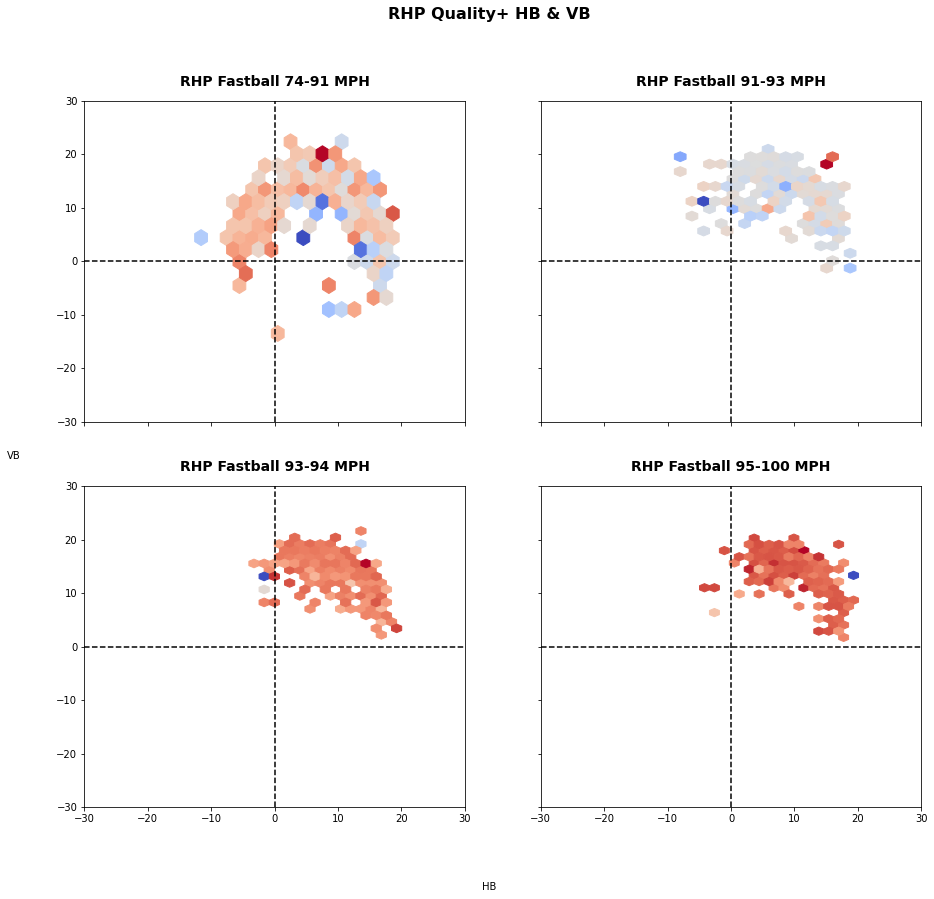

In [92]:
fig, axs = plt.subplots(2, 2, figsize = (15, 13), sharex = True, sharey = True)
fig.suptitle('RHP Quality+ HB & VB', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -30, xmax = 30), plt.axis(ymin = -30, ymax = 30)
fig.text(0.5, 0.04, 'HB', ha='center', va='center'), fig.text(0.06, 0.5, 'VB', ha='center', va='center')
axs[0][0].hexbin(bucket_1_r['pfx_x'], bucket_1_r['pfx_z'], C = bucket_1_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][0].axhline(0, color = 'black', ls = '--'),
axs[0][0].axvline(0, color = 'black', ls = '--')
axs[0][0].set_title('RHP Fastball 74-91 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[0][1].hexbin(bucket_2_r['pfx_x'], bucket_2_r['pfx_z'], C = bucket_2_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][1].axhline(0, color = 'black', ls = '--'),
axs[0][1].axvline(0, color = 'black', ls = '--')
axs[0][1].set_title('RHP Fastball 91-93 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][0].hexbin(bucket_3_r['pfx_x'], bucket_3_r['pfx_z'], C = bucket_3_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)

axs[1][0].axhline(0, color = 'black', ls = '--'),
axs[1][0].axvline(0, color = 'black', ls = '--')
axs[1][0].set_title('RHP Fastball 93-94 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][1].hexbin(bucket_4_r['pfx_x'], bucket_4_r['pfx_z'], C = bucket_4_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[1][1].axhline(0, color = 'black', ls = '--'),
axs[1][1].axvline(0, color = 'black', ls = '--')
axs[1][1].set_title('RHP Fastball 95-100 MPH', fontsize = 14, fontweight = 'bold', pad = 15);

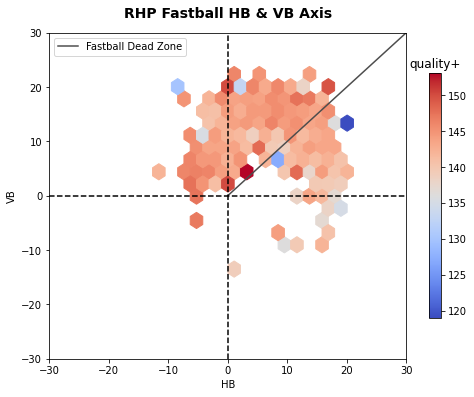

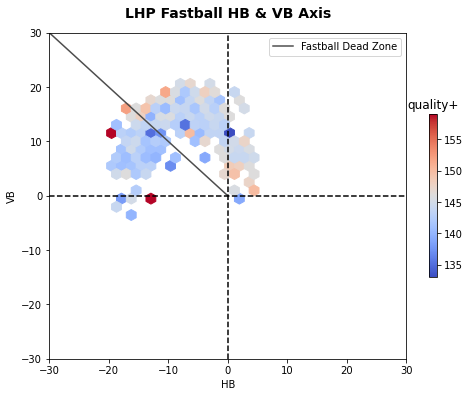

In [50]:
plt.figure(figsize = (8, 6))
plt.hexbin(fastball_r_lead['pfx_x'], fastball_r_lead['pfx_z'], C = fastball_r_lead['quality+'], 
           cmap = 'coolwarm', gridsize = 15)
plt.plot([30, 0], [30, 0], ls="-", c=".3", label = 'Fastball Dead Zone'), plt.legend()
cb = plt.colorbar(shrink = .75)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fastball_l_lead['pfx_x'], fastball_l_lead['pfx_z'], C = fastball_l_lead['quality+'], 
           cmap = 'coolwarm', gridsize = 15)
plt.plot([0, -30], [0, 30], ls="-", c=".3", label = 'Fastball Dead Zone'), plt.legend()
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball
Slider, Curveball, Knuckle Curve

In [51]:
g_sl = xrv.loc[xrv['pitch_type'] == 'SL']
g_cu = xrv.loc[xrv['pitch_type'] == 'CU']
bb_stats = g_sl.append(g_cu)
g_kc = xrv.loc[xrv['pitch_type'] == 'KC']
bb_stats = bb_stats.append(g_kc)
print(bb_stats.shape)

bb_r_stats = bb_stats.loc[bb_stats['p_throws'] == 'R']
bb_l_stats = bb_stats.loc[bb_stats['p_throws'] == 'L']

bb_stats.describe()

(194303, 17)


,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.000000,194303.0,194303.000000
mean,82.865326,2444.465361,-3.415627,-1.455009,0.806099,5.849946,40.777077,6.243116,-0.182905,1.869633,0.006327,1.0,0.014063
std,4.532022,287.177609,8.291327,6.860984,1.868011,0.555874,21.822627,0.449435,0.911115,0.978103,0.280442,0.0,0.166892
min,35.900000,95.000000,-34.080000,-25.560000,-4.430000,0.940000,0.700000,2.800000,-8.830000,-5.070000,-0.203000,1.0,-0.192000
25%,80.100000,2252.000000,-8.880000,-5.520000,-0.910000,5.600000,27.600000,5.900000,-0.800000,1.240000,-0.149000,1.0,-0.058000
50%,83.400000,2431.000000,-4.080000,-0.360000,1.480000,5.900000,35.900000,6.200000,-0.200000,1.880000,-0.007000,1.0,-0.011000
75%,86.100000,2627.000000,1.560000,3.480000,2.130000,6.190000,46.100000,6.500000,0.420000,2.500000,-0.004000,1.0,0.028000
max,95.500000,3722.000000,27.840000,28.800000,5.340000,7.930000,168.600000,8.400000,5.000000,9.390000,2.128000,1.0,1.639000


## Breaking Ball Leaders

In [52]:
bb_leaders = rv_pitches[rv_pitches['pitch_type'].isin(['SL', 'CU', 'KC'])]
bb_leaders = bb_leaders.sort_values(by = ['xRV/100'])
bb_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
bb_leaders['quality'] = [-x if x > 0 else -x for x in bb_leaders['xRV/100']]
bb_leaders.head(10)

scaler = StandardScaler(with_mean = False, with_std = False).fit(bb_leaders[['quality']])
rv_scaled = scaler.transform(bb_leaders[['quality']] + 150)

bb_leaders['quality+'] = rv_scaled
bb_leaders['quality+'] = round(bb_leaders['quality+']).astype(int)
bb_leaders.drop(columns = ['quality'], inplace = True)
bb_r_lead = bb_leaders.loc[bb_leaders['p_throws'] == 'R']
bb_l_lead = bb_leaders.loc[bb_leaders['p_throws'] == 'L']

bb_r_lead['velo_bucket'] = pd.qcut(bb_r_lead['velo'], 4, labels = [1, 2, 3, 4])
bb_l_lead['velo_bucket'] = pd.qcut(bb_l_lead['velo'], 4, labels = [1, 2, 3, 4])
bb_r_lead.head()

bucket_1_r = bb_r_lead.loc[bb_r_lead['velo_bucket'] == 1]
bucket_2_r = bb_r_lead.loc[bb_r_lead['velo_bucket'] == 2]
bucket_3_r = bb_r_lead.loc[bb_r_lead['velo_bucket'] == 3]
bucket_4_r = bb_r_lead.loc[bb_r_lead['velo_bucket'] == 4]

bucket_1_l = bb_l_lead.loc[bb_l_lead['velo_bucket'] == 1]
bucket_2_l = bb_l_lead.loc[bb_l_lead['velo_bucket'] == 2]
bucket_3_l = bb_l_lead.loc[bb_l_lead['velo_bucket'] == 3]
bucket_4_l = bb_l_lead.loc[bb_l_lead['velo_bucket'] == 4]

bb_leaders.head()

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100,quality+
2355,"Hembree, Heath",R,CU,5.0,83.0,-12.77,-10.15,22.1,6.76,-0.654,-13.08,163
2668,"Santiago, Héctor",L,CU,1.0,75.8,5.52,-7.68,85.2,5.70,-0.129,-12.90,163
2647,"Moreland, Mitch",L,CU,2.0,73.3,5.88,-10.02,85.3,5.75,-0.222,-11.10,161
2541,"Weems, Jordan",R,CU,1.0,75.0,-12.00,-12.00,28.4,6.50,-0.108,-10.80,161
2617,"Kickham, Mike",L,CU,4.0,77.2,12.60,-7.20,61.3,6.35,-0.421,-10.52,161


bucket 1: 39.6 - 78.8

bucket 2: 78.9 - 82.3

bucket 3: 82.4 - 85.4

bucket 4:85.5 - 91.9

### Breaking Ball HB & VB

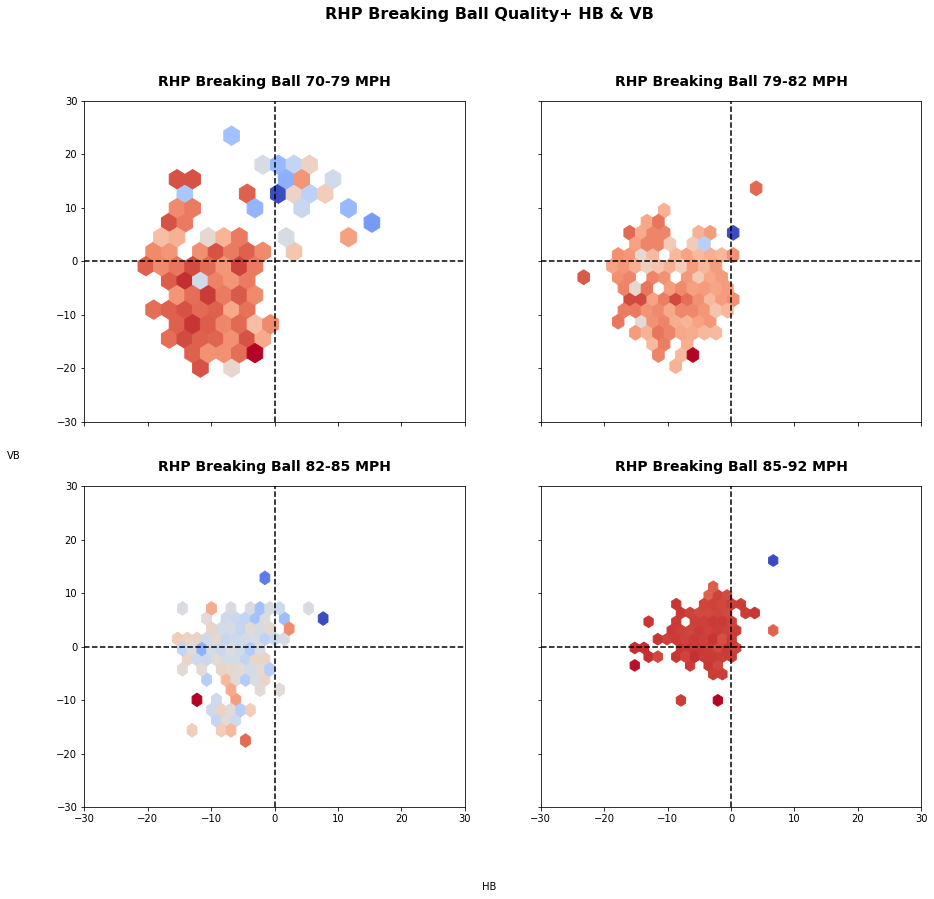

In [53]:
fig, axs = plt.subplots(2, 2, figsize = (15, 13), sharex = True, sharey = True)
fig.suptitle('RHP Breaking Ball Quality+ HB & VB', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -30, xmax = 30), plt.axis(ymin = -30, ymax = 30) 
fig.text(0.5, 0.04, 'HB', ha='center', va='center'), fig.text(0.06, 0.5, 'VB', ha='center', va='center')
axs[0][0].hexbin(bucket_1_r['pfx_x'], bucket_1_r['pfx_z'], C = bucket_1_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][0].axhline(0, color = 'black', ls = '--'),
axs[0][0].axvline(0, color = 'black', ls = '--')
#axs[0][0].fig.colorbar(shrink = .75)
#axs[0][0].ax.set_title('quality+')
axs[0][0].set_title('RHP Breaking Ball 70-79 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[0][1].hexbin(bucket_2_r['pfx_x'], bucket_2_r['pfx_z'], C = bucket_2_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][1].axhline(0, color = 'black', ls = '--'),
axs[0][1].axvline(0, color = 'black', ls = '--')
axs[0][1].set_title('RHP Breaking Ball 79-82 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][0].hexbin(bucket_3_r['pfx_x'], bucket_3_r['pfx_z'], C = bucket_3_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)

axs[1][0].axhline(0, color = 'black', ls = '--'),
axs[1][0].axvline(0, color = 'black', ls = '--')
axs[1][0].set_title('RHP Breaking Ball 82-85 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][1].hexbin(bucket_4_r['pfx_x'], bucket_4_r['pfx_z'], C = bucket_4_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[1][1].axhline(0, color = 'black', ls = '--'),
axs[1][1].axvline(0, color = 'black', ls = '--')
axs[1][1].set_title('RHP Breaking Ball 85-92 MPH', fontsize = 14, fontweight = 'bold', pad = 15);

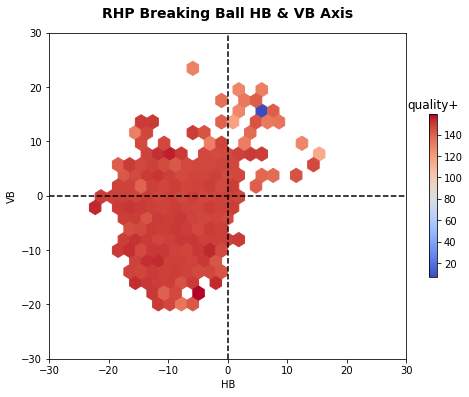

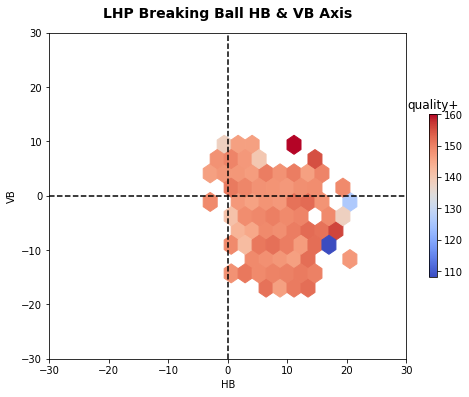

In [54]:
plt.figure(figsize = (8, 6))
plt.hexbin(bb_r_lead['pfx_x'], bb_r_lead['pfx_z'], C = bb_r_lead['quality+'], cmap = 'coolwarm', gridsize = 20)
# mincnt = 10
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(bb_l_lead['pfx_x'], bb_l_lead['pfx_z'], C = bb_l_lead['quality+'], cmap = 'coolwarm', gridsize = 10)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

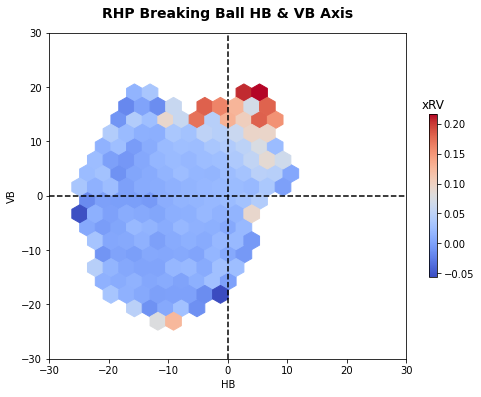

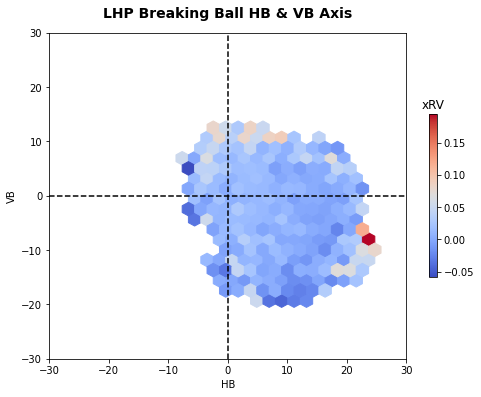

In [55]:
plt.figure(figsize = (8, 6))
plt.hexbin(bb_r_stats['pfx_x'], bb_r_stats['pfx_z'], C = bb_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('xRV'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(bb_l_stats['pfx_x'], bb_l_stats['pfx_z'], C = bb_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('xRV'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed
Changeup, Splitter

In [56]:
g_ch = xrv.loc[xrv['pitch_type'] == 'CH']
g_fs = xrv.loc[xrv['pitch_type'] == 'FS']
os_stats = g_ch.append(g_fs)
print(os_stats.shape)

os_r_stats = os_stats.loc[os_stats['p_throws'] == 'R']
os_l_stats = os_stats.loc[os_stats['p_throws'] == 'L']

os_stats.describe()

(80330, 17)


,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,arm_angle,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.0,80330.000000
mean,84.806887,1749.619781,3.593931,6.828759,0.469775,5.796717,45.671474,6.306985,0.040431,1.850276,0.023993,1.0,0.033105
std,3.524400,299.480706,13.825781,4.907631,2.039148,0.440081,23.259922,0.452686,0.874606,0.901523,0.300844,0.0,0.179340
min,43.800000,43.000000,-27.000000,-15.720000,-4.460000,2.160000,0.100000,3.700000,-9.110000,-3.580000,-0.203000,1.0,-0.187000
25%,82.600000,1546.000000,-12.720000,3.600000,-1.710000,5.530000,31.200000,6.000000,-0.560000,1.260000,-0.149000,1.0,-0.040000
50%,85.100000,1714.000000,11.160000,6.960000,1.400000,5.820000,38.700000,6.300000,0.050000,1.840000,-0.007000,1.0,-0.001000
75%,87.200000,1935.000000,15.120000,10.200000,2.090000,6.090000,51.800000,6.600000,0.630000,2.420000,0.000000,1.0,0.046000
max,95.500000,3595.000000,29.640000,23.400000,4.580000,7.280000,164.600000,9.000000,4.680000,8.390000,2.128000,1.0,1.593000


### Off-Speed Leaders

In [57]:
os_leaders = rv_pitches[rv_pitches['pitch_type'].isin(['CH', 'FS'])]
os_leaders = os_leaders.sort_values(by = ['xRV/100'])
os_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
os_leaders['quality'] = [-x if x > 0 else -x for x in os_leaders['xRV/100']]
os_leaders.head(10)

scaler = StandardScaler(with_mean = False, with_std = False).fit(os_leaders[['quality']])
rv_scaled = scaler.transform(os_leaders[['quality']] + 150)

os_leaders['quality+'] = rv_scaled
os_leaders['quality+'] = round(os_leaders['quality+']).astype(int)
os_leaders.drop(columns = ['quality'], inplace = True)
os_r_lead = os_leaders.loc[os_leaders['p_throws'] == 'R']
os_l_lead = os_leaders.loc[os_leaders['p_throws'] == 'L']

os_r_lead['velo_bucket'] = pd.qcut(os_r_lead['velo'], 4, labels = [1, 2, 3, 4])
os_l_lead['velo_bucket'] = pd.qcut(os_l_lead['velo'], 4, labels = [1, 2, 3, 4])
bucket_1_r = os_r_lead.loc[os_r_lead['velo_bucket'] == 1]
bucket_2_r = os_r_lead.loc[os_r_lead['velo_bucket'] == 2]
bucket_3_r = os_r_lead.loc[os_r_lead['velo_bucket'] == 3]
bucket_4_r = os_r_lead.loc[os_r_lead['velo_bucket'] == 4]

bucket_1_l = os_l_lead.loc[os_l_lead['velo_bucket'] == 1]
bucket_2_l = os_l_lead.loc[os_l_lead['velo_bucket'] == 2]
bucket_3_l = os_l_lead.loc[os_l_lead['velo_bucket'] == 3]
bucket_4_l = os_l_lead.loc[os_l_lead['velo_bucket'] == 4]


os_leaders.head()

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,arm_angle,release_extension,xRV,xRV/100,quality+
3002,"Nogosek, Stephen",R,CH,1.0,87.3,13.32,10.08,35.6,6.1,-0.139,-13.90,164
2794,"Darvish, Yu",R,CH,1.0,80.2,13.56,6.48,27.8,6.6,-0.126,-12.60,163
2923,"Kela, Keone",R,CH,1.0,89.5,13.92,9.96,27.3,6.6,-0.126,-12.60,163
2890,"Hendriks, Liam",R,CH,1.0,91.6,11.64,21.12,28.3,6.9,-0.103,-10.30,160
3139,"Weigel, Patrick",R,CH,2.0,86.2,14.46,5.88,40.7,6.2,-0.203,-10.15,160


bucket 1: 44.8 - 84.3 mph

bucket 2: 84.4 - 86.2 mph

bucket 3: 86.3 - 87.8 mph

bucket 4: 87.9 - 92.3

### Off-Speed HB & VB

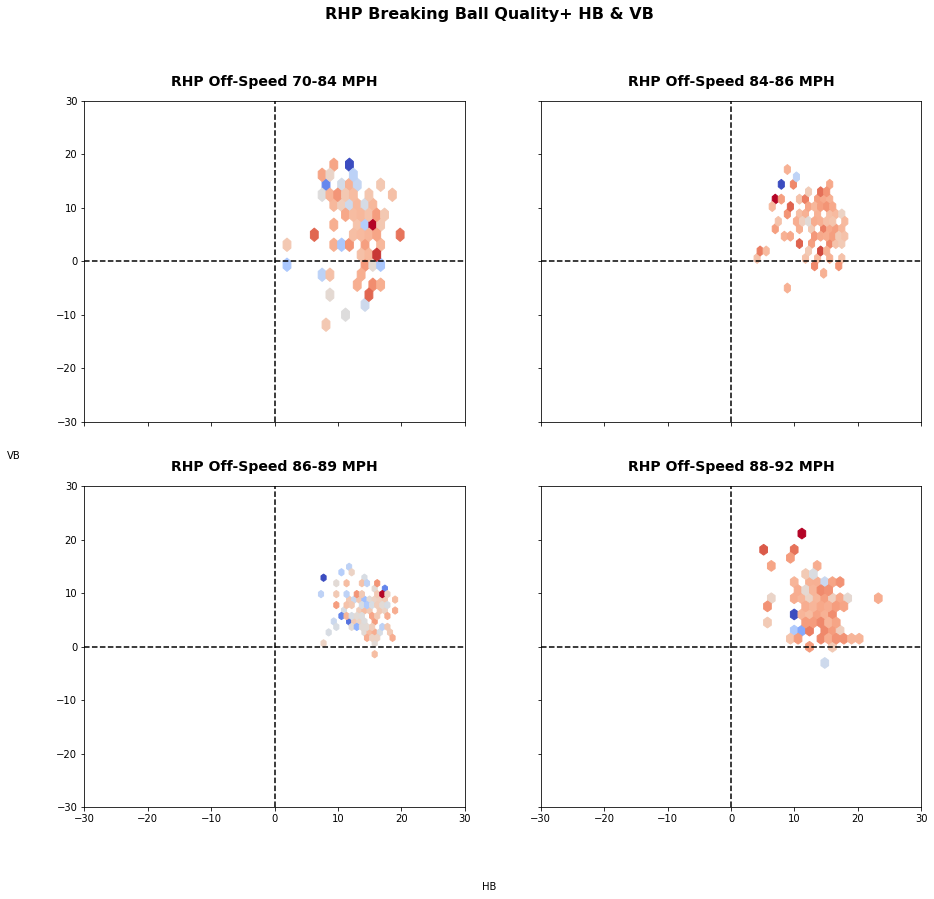

In [58]:
fig, axs = plt.subplots(2, 2, figsize = (15, 13), sharex = True, sharey = True)
fig.suptitle('RHP Breaking Ball Quality+ HB & VB', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -30, xmax = 30), plt.axis(ymin = -30, ymax = 30) 
fig.text(0.5, 0.04, 'HB', ha='center', va='center'), fig.text(0.06, 0.5, 'VB', ha='center', va='center')
axs[0][0].hexbin(bucket_1_r['pfx_x'], bucket_1_r['pfx_z'], C = bucket_1_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][0].axhline(0, color = 'black', ls = '--'),
axs[0][0].axvline(0, color = 'black', ls = '--')
#axs[0][0].fig.colorbar(shrink = .75)
#axs[0][0].ax.set_title('quality+')
axs[0][0].set_title('RHP Off-Speed 70-84 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[0][1].hexbin(bucket_2_r['pfx_x'], bucket_2_r['pfx_z'], C = bucket_2_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[0][1].axhline(0, color = 'black', ls = '--'),
axs[0][1].axvline(0, color = 'black', ls = '--')
axs[0][1].set_title('RHP Off-Speed 84-86 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][0].hexbin(bucket_3_r['pfx_x'], bucket_3_r['pfx_z'], C = bucket_3_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)

axs[1][0].axhline(0, color = 'black', ls = '--'),
axs[1][0].axvline(0, color = 'black', ls = '--')
axs[1][0].set_title('RHP Off-Speed 86-89 MPH', fontsize = 14, fontweight = 'bold', pad = 15)

axs[1][1].hexbin(bucket_4_r['pfx_x'], bucket_4_r['pfx_z'], C = bucket_4_r['quality+'], cmap = 'coolwarm', 
                 gridsize = 15)
axs[1][1].axhline(0, color = 'black', ls = '--'),
axs[1][1].axvline(0, color = 'black', ls = '--')
axs[1][1].set_title('RHP Off-Speed 88-92 MPH', fontsize = 14, fontweight = 'bold', pad = 15);

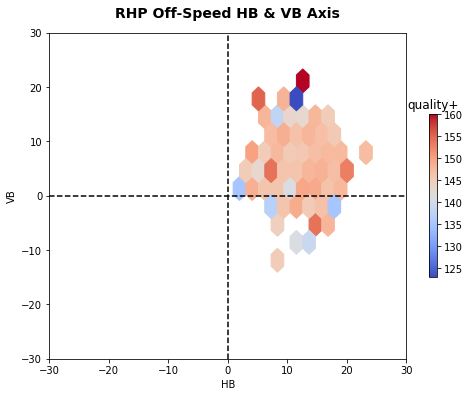

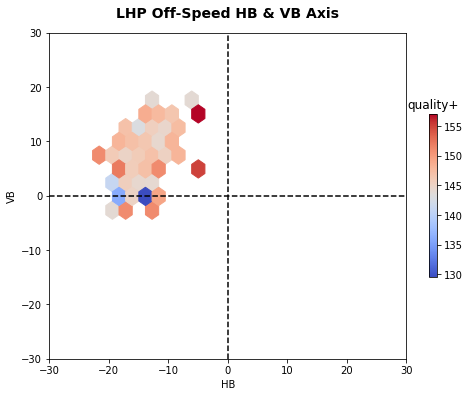

In [59]:
plt.figure(figsize = (8, 6))
plt.hexbin(os_r_lead['pfx_x'], os_r_lead['pfx_z'], C = os_r_lead['quality+'], cmap = 'coolwarm', gridsize = 10)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(os_l_lead['pfx_x'], os_l_lead['pfx_z'], C = os_l_lead['quality+'], cmap = 'coolwarm', gridsize = 8)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('quality+'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

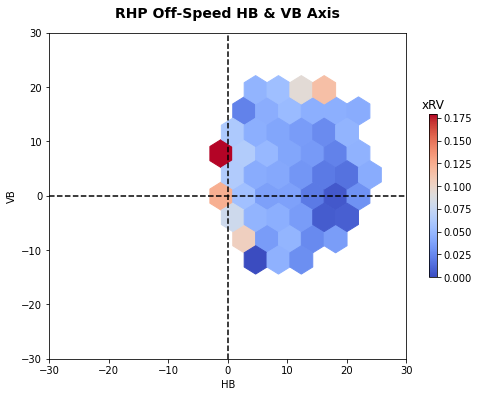

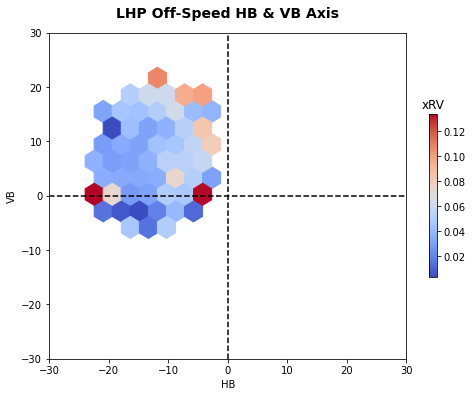

In [60]:
plt.figure(figsize = (8, 6))
plt.hexbin(os_r_stats['pfx_x'], os_r_stats['pfx_z'], C = os_r_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 10)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('xRV'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(os_l_stats['pfx_x'], os_l_stats['pfx_z'], C = os_l_stats['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 10)
cb = plt.colorbar(shrink = .5)
plt.xlabel('HB'), plt.ylabel('VB'), cb.ax.set_title('xRV'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

In [ ]:
#ff_stats.to_csv('../data/four-seam-quality.csv')
#fc_stats.to_csv('../data/cutter-quality.csv')
#si_stats.to_csv('../data/sinker-quality.csv')
#sl_stats.to_csv('../data/slider-quality.csv')
#cu_stats.to_csv('../data/curveball-quality.csv')
#ch_stats.to_csv('../data/changeup-quality.csv')
#fastball_stats.to_csv('../data/fastball-quality.csv')
#bb_stats.to_csv('../data/breaking-ball-quality.csv')
#os_stats.to_csv('../data/off-speed-quality.csv')